In [95]:
from datetime import datetime
import keras
from keras.optimizers import Adam, SGD, RMSprop
from numpy import linspace
from landsat import load_landsat_data
from eval_model import eval_model, tune_model
import pandas as pd

from wame import WAME

Load the train and test sets

In [57]:
x_train, y_train = load_landsat_data("sat.trn")
x_test, y_test = load_landsat_data("sat.tst")
from collections import Counter
print(Counter(y_train))

Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1})


Optimise the WAME params

In [58]:
#tune_model(x_train, y_train, x_test, y_test, wame_opt)

Best: 28.235916 using {'epochs': 100, 'batch_size': 40}

rerun with different hyperparameters

In [59]:
#tune_model(x_train, y_train, x_test, y_test)

### Model Summary

In [66]:
from eval_model import create_model

create_model(x_train.shape[1:], WAME()).summary()


3 layer model
Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       (None, 36)                0         
_________________________________________________________________
dense_641 (Dense)            (None, 64)                2368      
_________________________________________________________________
dense_642 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_161 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_643 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_644 (Dense)            (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_______________________________________

In [101]:
from eval_model import eval_model

scores={}
times={}
durations={}
iterations = [60, 120, 180, 240, 300]
optimizers = [Adam(1e-5), WAME(epsilon=0.01), SGD(), RMSprop(learning_rate=0.01)]
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    scores[opt_name] = []
    times[opt_name] = []
    durations[opt_name] = []
    for iteration in iterations:
        print(opt_name, iteration)
        start_time = datetime.now()
        score, time = eval_model(x_train, y_train, x_test, y_test, optimizer, iteration, opt_name)
        duration = (datetime.now()-start_time).total_seconds()
        print(f"{opt_name} {iteration}: {duration}")
        scores[opt_name].append(score)
        times[opt_name].append(time)
        durations[opt_name].append(duration)

Adam 60
3 layer model
2000/2000 [==============================] - 0s 23us/step
Adam 60: 10.772892
Adam 120
3 layer model
2000/2000 [==============================] - 0s 23us/step
Adam 120: 19.247254
Adam 180
3 layer model
2000/2000 [==============================] - 0s 22us/step
Adam 180: 28.320045
Adam 240
3 layer model
2000/2000 [==============================] - 0s 20us/step
Adam 240: 41.103819
Adam 300
3 layer model
2000/2000 [==============================] - 0s 22us/step
Adam 300: 53.155509
WAME 60
3 layer model
2000/2000 [==============================] - 0s 23us/step
WAME 60: 11.859741
WAME 120
3 layer model
2000/2000 [==============================] - 0s 22us/step

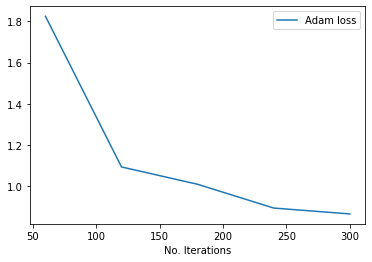

Adam best score 0.8659272933006287
WAME best score 3.1796405267715455
SGD best score 0.5811068350076676
RMSprop best score 1.7746642160415649


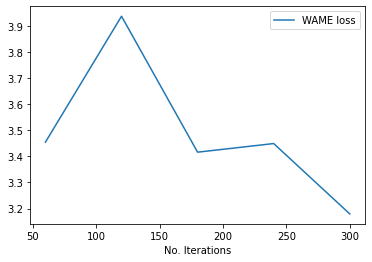

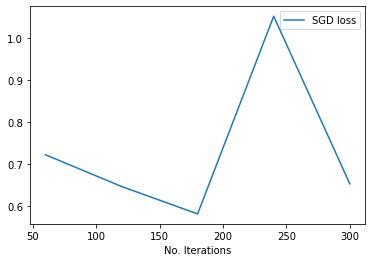

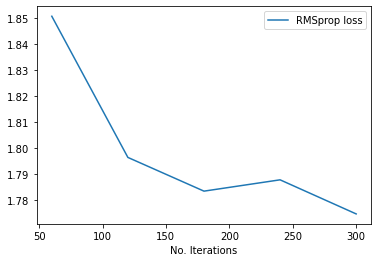

In [90]:
import matplotlib.pyplot as plt

for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    plt.plot(iterations, scores[opt_name], label = f"{opt_name} loss")

    plt.xlabel('No. Iterations')
    plt.legend()
    plt.savefig( f"figures/{opt_name}-score.png")
    plt.show()
    print(f"{opt_name} best score {min(scores[opt_name])}")

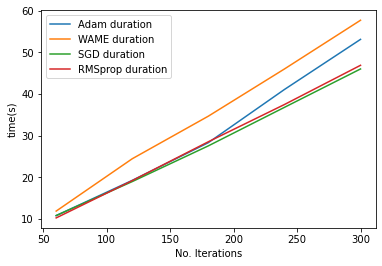

          Adam       WAME        SGD    RMSprop
60   10.772892  11.859741  10.785231  10.219459
120  19.247254  24.450373  18.957702  19.192914
180  28.320045  34.688663  27.547161  28.534963
240  41.103819  46.036945  36.807399  37.486725
300  53.155509  57.753125  46.042100  46.922082


In [113]:
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    plt.plot(iterations, durations[opt_name], label = f"{opt_name} duration")

plt.xlabel('No. Iterations')
plt.ylabel('time(s)')
plt.legend()
plt.savefig( f"figures/all-durations.png")
plt.show()

dfd = pd.DataFrame(durations, index=[str(i) for i in iterations])
print(dfd)

Time vs Iteration for all Optimizers


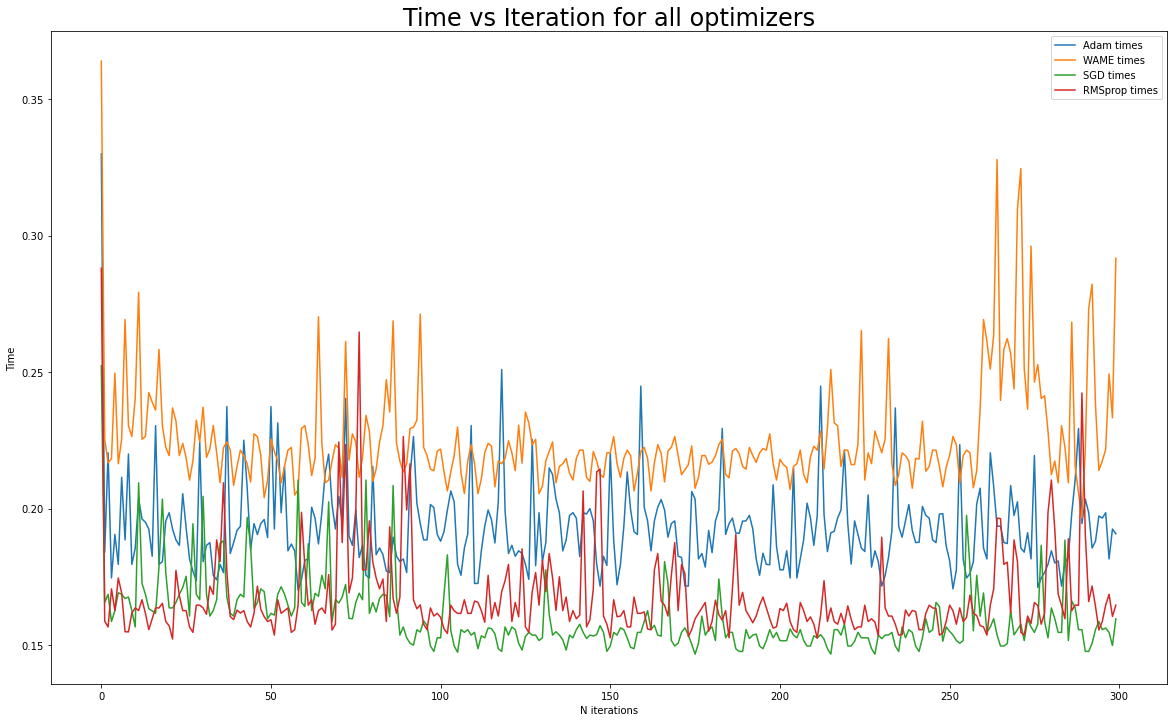

In [91]:
print ("Time vs Iteration for all Optimizers")
plt.figure(figsize=(20,12))
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    seq = times[opt_name][-1]
    plt.plot(seq, label = f"{opt_name} times")

plt.xlabel('N iterations')
plt.ylabel('Time')
plt.title('Time vs Iteration for all optimizers',fontsize=24)
plt.legend()
plt.savefig( f"figures/all-optimizers.png")
plt.show()

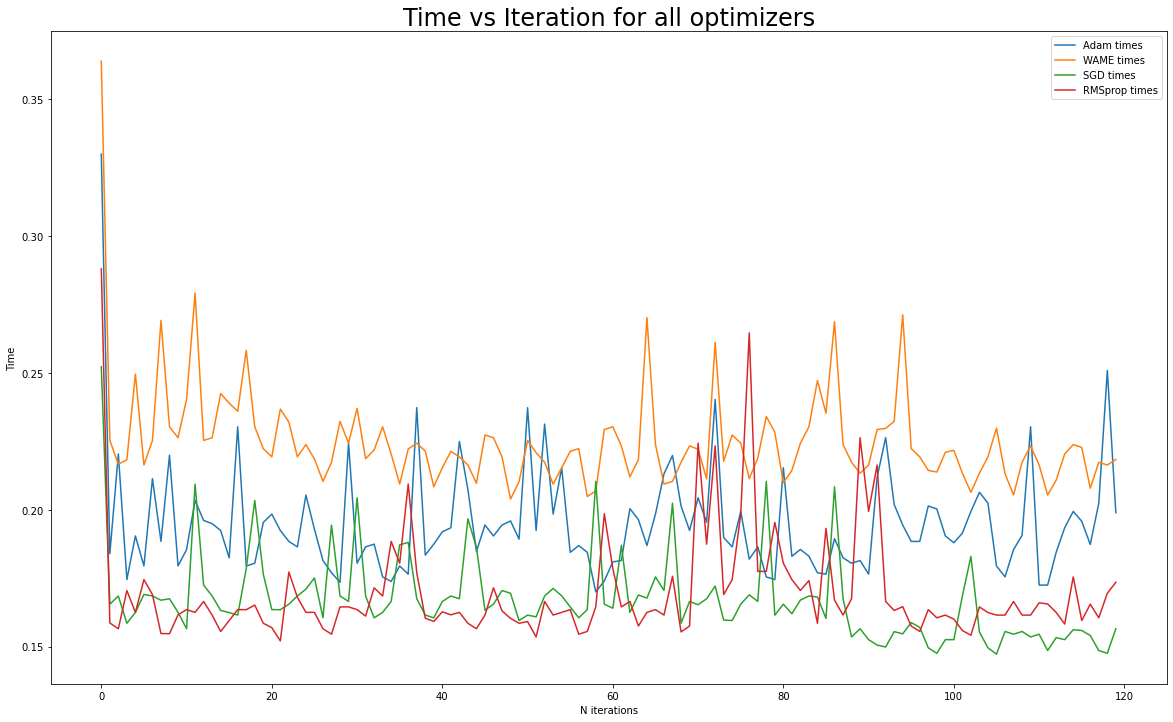

In [92]:
plt.figure(figsize=(20,12))
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    seq = times[opt_name][-1][0:120]

    plt.plot(seq, label = f"{opt_name} times")

plt.xlabel('N iterations')
plt.ylabel('Time')
plt.title('Time vs Iteration for all optimizers',fontsize=24)
plt.legend()
plt.savefig( f"figures/all-optimizers-to-120.png")
plt.show()



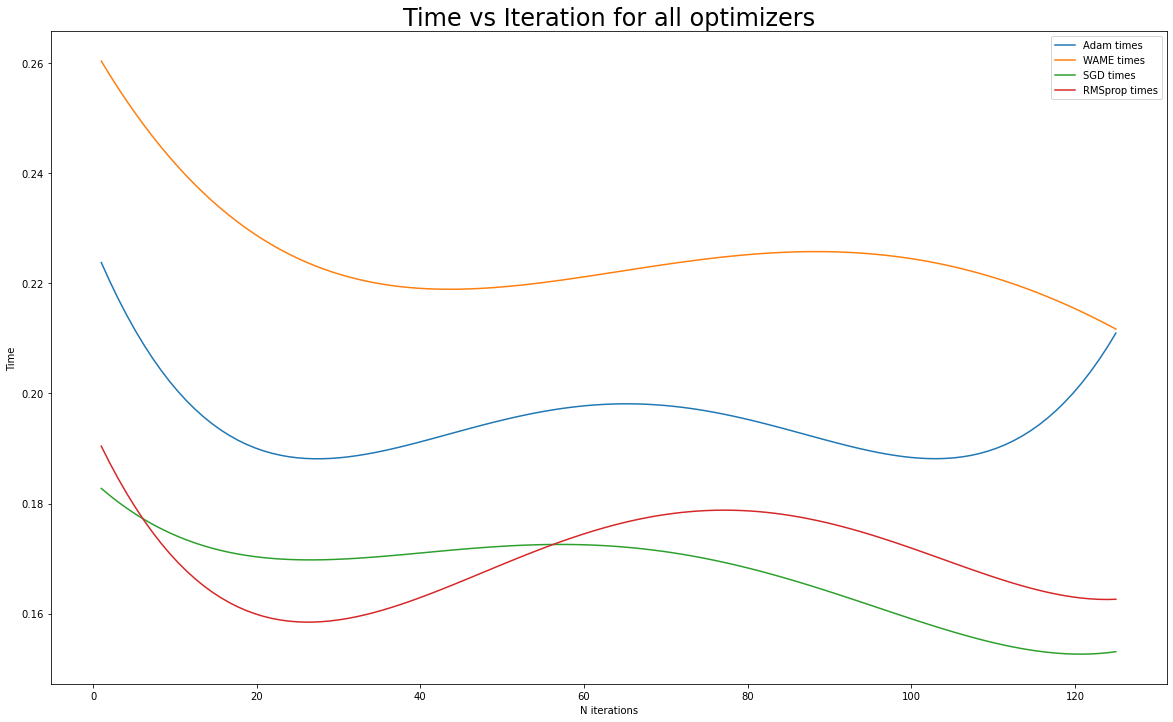

In [64]:
import numpy as np

plt.figure(figsize=(20,12))
x_new = linspace(1,125,120)
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    seq = times[opt_name][-1][0:120]
    coeffs = np.polyfit(x_new,seq,4)
    poly = np.poly1d(coeffs)
    y_new = poly(x_new)


    plt.plot(x_new, y_new, label = f"{opt_name} times")

plt.xlabel('N iterations')
plt.ylabel('Time')
plt.title('Time vs Iteration for all optimizers',fontsize=24)
plt.legend()
plt.savefig( f"figures/all-optimizers-poly.png")
plt.show()

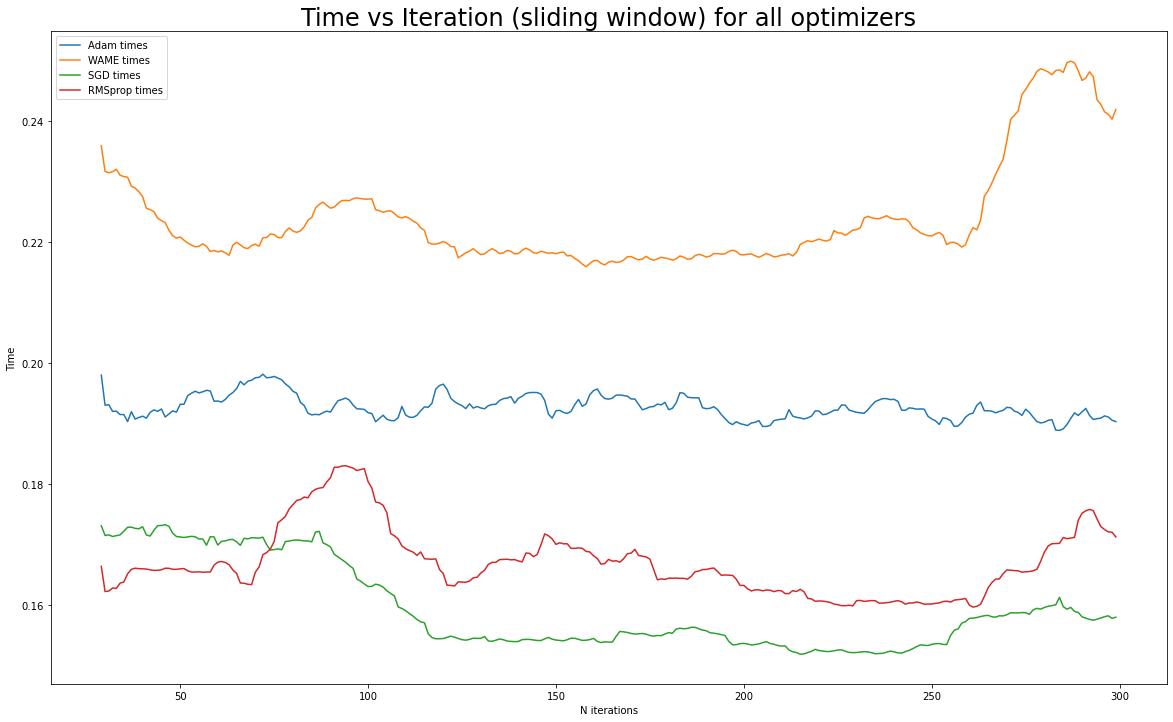

In [94]:
import numpy as np


plt.figure(figsize=(20,12))
x_new = linspace(1,125,120)
df = pd.DataFrame()
for optimizer in optimizers:
    opt_name = optimizer.__class__.__name__
    seq = times[opt_name][-1]
    
    df[opt_name] = seq
    rolling_mean = df[opt_name].rolling(window=30).mean()
    plt.plot(rolling_mean, label = f"{opt_name} times")

plt.xlabel('N iterations')
plt.ylabel('Time')
plt.title('Time vs Iteration (sliding window) for all optimizers',fontsize=24)
plt.legend()
plt.savefig( f"figures/all-optimizers-window.png")
plt.show()